**Adversarial debaising for Adult dataset**

In [1]:
!pip install aif360==0.3.0rc0

In [2]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_compas, load_preproc_data_german

from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

import tensorflow as tf

Matplotlib Error, comment out matplotlib.use('TkAgg')


In [3]:
# Get the dataset and split into train and test
dataset_orig = load_preproc_data_adult()

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [4]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


In [5]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.195566
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.192082


In [6]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())

#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.195566
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.192082


In [7]:
# Learn parameters with debias set to False
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 3.8MB 53.5MB/s 
     |████████████████████████████████| 512kB 51.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=7e88e44d804986c3422c5e9f8dd9428d32f094d1d8b2cde184d9c0c9809673b4
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tens

In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
plain_model.fit(dataset_orig_train)





The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





epoch 0; iter: 0; batch classifier loss: 0.712414
epoch 0; iter: 200; batch classifier loss: 0.472241
epoch 1; iter: 0; batch classifier loss: 0.405866
epoch 1; iter: 200; batch classifier loss: 0.401715
epoch 2; iter: 0; batch classifier loss: 0.410975
epoch 2; iter: 200; batch classifier loss: 0.442653
epoch 3; iter: 0; batch classifier loss: 0.353604
epoch 3; iter: 200; batch classifier loss: 0.508126
epoch 4; it

In [9]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

In [10]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.206280
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.204130


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.801269
Test set: Balanced classification accuracy = 0.654470
Test set: Disparate impact = 0.000000
Test set: Equal opportunity difference = -0.439049
Test set: Average odds difference = -0.269988
Test set: Theil_index = 0.183564


Apply Adversarial debaising


In [11]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()

In [12]:
# Learn parameters with debias set to True
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)

In [13]:
debiased_model.fit(dataset_orig_train)

epoch 0; iter: 0; batch classifier loss: 0.716542; batch adversarial loss: 0.721006
epoch 0; iter: 200; batch classifier loss: 0.422230; batch adversarial loss: 0.669826
epoch 1; iter: 0; batch classifier loss: 0.331134; batch adversarial loss: 0.651954
epoch 1; iter: 200; batch classifier loss: 0.432029; batch adversarial loss: 0.637296
epoch 2; iter: 0; batch classifier loss: 0.534935; batch adversarial loss: 0.601235
epoch 2; iter: 200; batch classifier loss: 0.451641; batch adversarial loss: 0.653406
epoch 3; iter: 0; batch classifier loss: 0.409940; batch adversarial loss: 0.611997
epoch 3; iter: 200; batch classifier loss: 0.383987; batch adversarial loss: 0.602691
epoch 4; iter: 0; batch classifier loss: 0.398910; batch adversarial loss: 0.651690
epoch 4; iter: 200; batch classifier loss: 0.439070; batch adversarial loss: 0.659149
epoch 5; iter: 0; batch classifier loss: 0.473988; batch adversarial loss: 0.630691
epoch 5; iter: 200; batch classifier loss: 0.469297; batch adversa

In [14]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

In [15]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())



display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.206280
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.204130


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.085895
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.089551


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.801269
Test set: Balanced classification accuracy = 0.654470
Test set: Disparate impact = 0.000000
Test set: Equal opportunity difference = -0.439049
Test set: Average odds difference = -0.269988
Test set: Theil_index = 0.183564


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.791442
Test set: Balanced classification accuracy = 0.667944
Test set: Disparate impact = 0.561305
Test set: Equal opportunity difference = -0.063368
Test set: Average odds difference = -0.041513
Test set: Theil_index = 0.174524


In [22]:
import seaborn

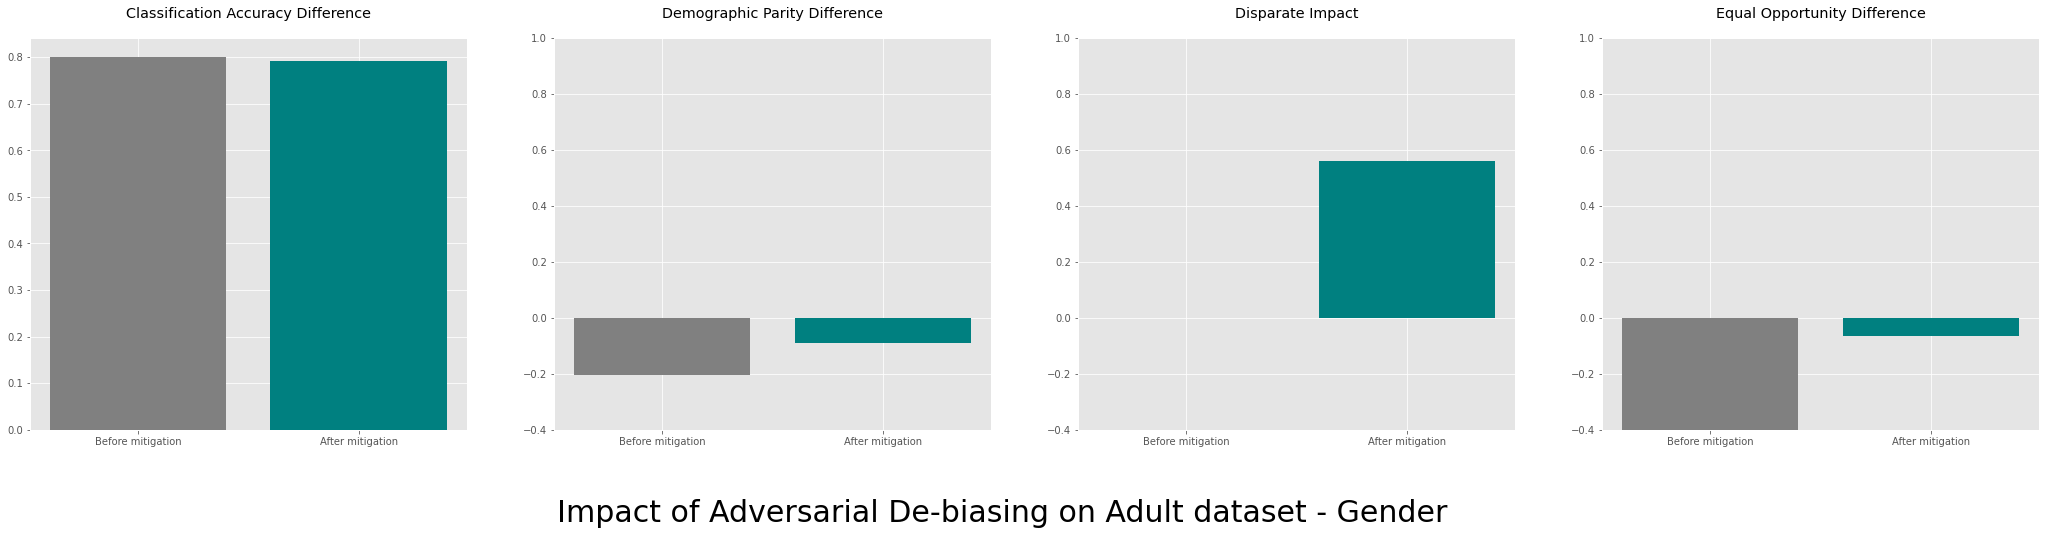

In [39]:
def plot_metrics(metrics_before, metrics_after, 
                 sensitive_attr='Gender',
                 mitigation='Adversarial De-biasing', dataset='Adult'):
    total = 4; cols = 4
    rows = total //cols; rows += total % cols
    pos = range(1, total+1)

    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from cycler import cycler
    plt.style.use('ggplot')
    mpl.rcParams['lines.linewidth'] = 2
    mpl.rcParams['lines.linestyle'] = '--' 

    fig = plt.figure(figsize=(36,rows*8))
    x_pos = [1,2]
    kwargs = {
        'color': ['grey', 'teal'],
        'tick_label': ['Before mitigation', 'After mitigation']
    }
    
    i = 0; subplot_pad=20

    ax = fig.add_subplot(rows, cols, pos[i])
    ax.set_title('Classification Accuracy Difference', pad=subplot_pad)
    import seaborn as sns
    ax.bar(x_pos, [metrics_before.accuracy(), metrics_after.accuracy()],
                  **kwargs)

    metrics = {'Demographic Parity Difference': 'mean_difference',
               'Disparate Impact': 'disparate_impact',
               'Equal Opportunity Difference': 'equal_opportunity_difference'}
    
    for title, methodname in  metrics.items():
        i += 1;
        ax = fig.add_subplot(rows, cols, pos[i])
        ax.set_title(title, pad=subplot_pad)
        ax.set_ylim([-0.4,1])
        ax.bar(x_pos, 
                     [getattr(metrics_before, methodname)(), getattr(metrics_after, methodname)()],
                     **kwargs)
        
    fig.subplots_adjust(bottom=0.2)
    title = 'Impact of {} on {} dataset - {}'.format(mitigation, dataset, sensitive_attr)
    fig.suptitle(title, y=0.08)
    # fig.savefig('figures/'+title+'.png')
    plt.show()

font = {'font.size'   : 18,
        'figure.titlesize': 30}
plt.rcParams.update(font)

plot_metrics(classified_metric_nodebiasing_test, classified_metric_debiasing_test)